In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime


import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

Как рассчитывать бету: отдавать 0, между сырыми ценами, между доходностями или между фильтрованными доходностями

In [3]:
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [4]:
MAX_ALPHA_VALUE = 1e6

In [5]:
DATE_FROM = '2010-01-01'
DATE_TO = '2018-12-31'
TEST_DATE_FROM = '2016-01-01'
TEST_DATE_TO = '2019-12-31'
REAL_DATE_FROM = '2018-01-01'
REAL_DATE_TO = '2020-09-22'
tickers = ['ARE', 'CTL', 'NKE', 'AAP', 'MMM',
           'QCOM', 'TIF', 'APD', 'ATO', 'MSFT',
           'ZBH', 'WYNN', 'WY', 'DIS', 'ULTA',
           'TXT', 'TXN', 'STE', 'SEE', 'PEG']
SPY_TICKER = '^GSPC'

INITIAL_CASH = 500000
FEE = 0.001
MAX_POSITION_PER_EQUITY = max(1. / len(tickers), 0.95)
MAX_POSITION_PER_EQUITY_PER_TRADE = max(1. / len(tickers), 0.05)
MIN_DEAL_SIZE = 5000
MAX_DRAWDOWN_PER_DAY = 0.005
MAX_DRAWDOWN_PER_WEEK = 0.02

In [6]:
BETA_TYPE = BetaType.FILTERED
BETA_LAG = 30
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 30
GARCH_REFIT_DELAY_DAYS = 30

In [7]:
MEAN_MODEL = "HARX"
VOL_MODEL = "Garch"
DISTRIBUTION_ = "Normal"

In [8]:
p_ = 2
o_ = 0
q_ = 2

Функция для поиска лучших параметров для гарч

In [9]:
def _find_best_model_params(TS: pd.Series):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1, 5) # [1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order

Функция для отрисовки графиков для time series

In [10]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

Получение сырых цен

In [11]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to).dropna()
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

трансформация цен в доходности

In [12]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

бета

In [13]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.var(ddof=lag)

гарч фильтрация

In [14]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean,
                       lags=lag,
                       vol=vol, 
                       p=p, o=o, q=q,
                       dist=dist)

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    varis = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, varis

гарч фильтрация рядов доходностей для всех тикеров

In [15]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                              p=p_, o=o_, q=q_)
        #net_market_returns_f[ticker] = fltr_res[GARCH_LAG:]
        net_market_returns_f[ticker] = fltr_res[:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

Функция для удаления строки и столбца из корреляционной матрицы

In [16]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

Функция для расчета вектора alpha

In [17]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
        if abs(alphas[ticker]) > MAX_ALPHA_VALUE:
            alphas[ticker] = math.copysign(MAX_ALPHA_VALUE, alphas[ticker])
    return pd.DataFrame(alphas, columns=tickers, index=[0])

In [18]:
def alpha(mu, real_return):
    return 2 * mu - real_return



загружаем сырые данные и кладем в дата фрейм

In [19]:
spy_p = raw_adj_close_prices(SPY_TICKER, DATE_FROM, REAL_DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, REAL_DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [20]:
spy_p

Date
2009-12-31    1115.099976
2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
                 ...     
2020-09-15    3401.199951
2020-09-16    3385.489990
2020-09-17    3357.010010
2020-09-18    3319.469971
2020-09-21    3281.060059
Freq: D, Name: Adj Close, Length: 2699, dtype: float64

In [21]:
#tsplot(spy_p)
rp_df

,ARE,CTL,NKE,AAP,MMM,QCOM,TIF,APD,ATO,MSFT,ZBH,WYNN,WY,DIS,ULTA,TXT,TXN,STE,SEE,PEG
Date,,,,,,,,,,,,,,,,,,,,
2009-12-31,46.662109,15.142243,12.066024,39.191139,62.065166,34.575569,34.782131,55.806805,21.044086,23.801456,54.726418,38.204304,30.558327,28.090706,17.959049,18.319345,19.787371,23.630106,17.920336,21.763288
2010-01-04,46.125008,15.330424,11.934528,39.094307,62.327927,35.083817,35.582924,57.252583,21.129984,24.168472,55.568928,41.963718,31.365839,27.933924,18.641415,18.543341,19.749405,23.900459,18.051498,22.012022
2010-01-05,45.638733,15.355515,11.982012,38.861965,61.937550,35.928398,35.817501,56.777538,20.908096,24.176279,57.328018,44.515926,32.031689,27.864237,18.552410,18.192724,19.635513,23.875114,17.862947,21.992380
2010-01-06,45.399200,14.753342,11.908962,39.200817,62.815929,35.577103,36.367546,56.309391,20.915245,24.027906,57.309509,43.932011,31.677519,27.716166,19.007318,18.825777,19.491249,23.849764,17.518646,21.874559
2010-01-07,45.820171,14.611156,12.025843,39.191139,62.860950,36.608547,37.928696,55.985802,20.714825,23.778025,58.624191,44.870213,31.535852,27.724878,20.629171,19.663340,19.551987,23.503378,17.698996,21.580029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15,163.649994,10.990000,119.269997,156.626389,166.570007,116.580002,113.475792,304.040009,92.349998,208.779999,144.300003,82.279999,28.760000,131.240005,237.320007,39.070000,140.639999,169.639999,38.610001,51.650002
2020-09-16,164.639999,11.000000,118.589996,154.389999,169.509995,114.559998,115.276672,302.459991,93.889999,205.050003,145.929993,79.660004,28.930000,132.089996,239.940002,39.610001,139.679993,170.160004,38.830002,53.000000
2020-09-17,162.039993,11.000000,116.360001,154.759995,172.380005,114.879997,114.619995,301.980011,93.419998,202.910004,142.789993,79.300003,28.680000,130.220001,234.729996,39.110001,140.399994,171.509995,39.230000,52.240002


<Figure size 1152x360 with 0 Axes>

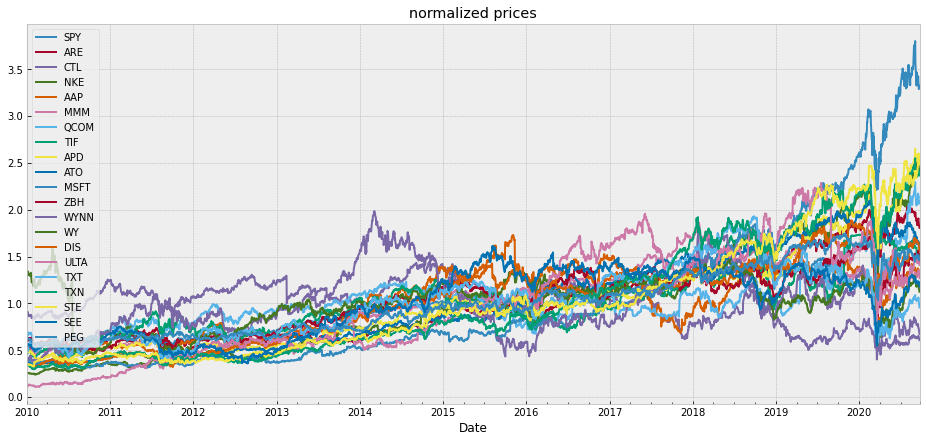

In [22]:
plt.figure(figsize=(16, 5))

plt.figure(figsize=(16,7))
plt.title("normalized prices")
pic = (spy_p / spy_p.mean()).plot(label='SPY')
for ticker, data in rp_df.iteritems():
    pic.plot((data / data.mean()), label=ticker)

plt.legend()
plt.show()

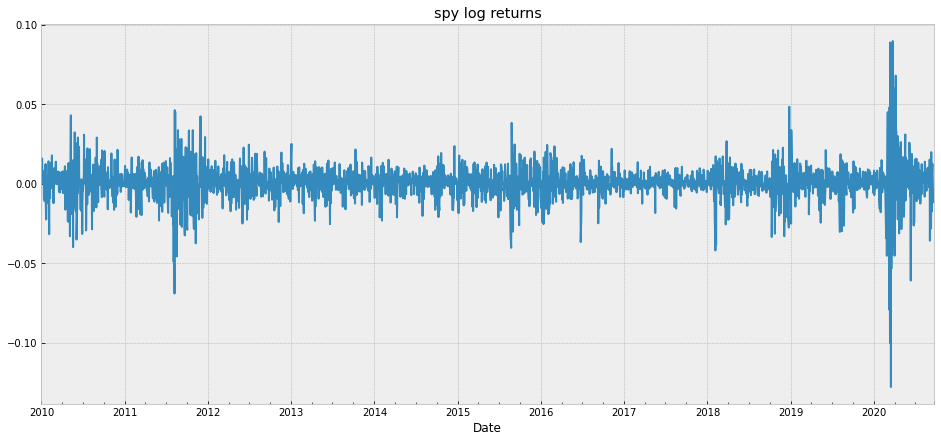

In [23]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

In [24]:
# tsplot(spy)

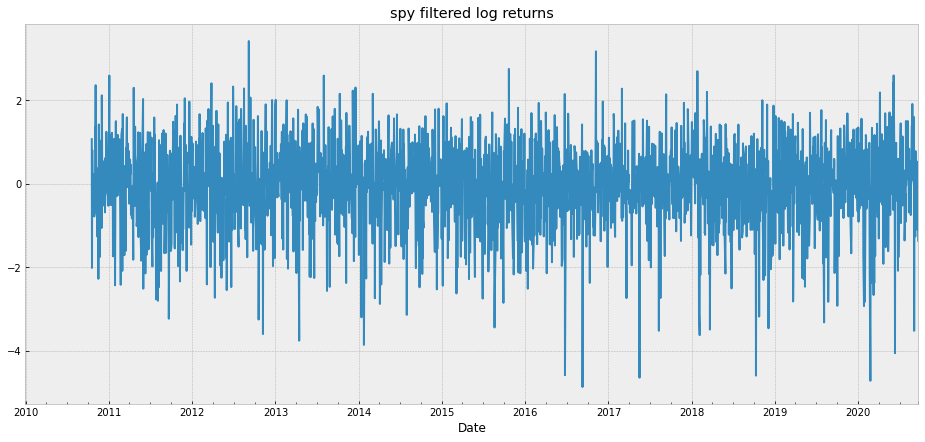

In [25]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                p=p_, o=o_, q=q_)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

In [26]:
# tsplot(spyf)

тесты на стационарность

In [27]:
# res = spy_p.values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
    
# res = spy.values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
    
# res = spyf.dropna().values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [28]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

раскомментировать, чтобы подбирать параметры garch

In [29]:
# %%time
# aic, params = _find_best_model_params(spy)

In [30]:
# for ticker in tickers:
#    aic, params = _find_best_model_params(mkt_returns[ticker])

считаем беты

In [31]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_, 
                                              p=p_, o=o_, q=q_)
        filtered_returns[ticker] = fltr_res[GARCH_LAG:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp 

CPU times: user 17min 44s, sys: 15min 19s, total: 33min 3s
Wall time: 4min 20s


{'ARE': 0.44162974767486124,
 'CTL': 0.3950151160844432,
 'NKE': 0.49102349825229985,
 'AAP': 0.35475430386776957,
 'MMM': 0.6319026886341567,
 'QCOM': 0.5287323223889449,
 'TIF': 0.4602324742537604,
 'APD': 0.6141129148957757,
 'ATO': 0.3930432935246204,
 'MSFT': 0.6230537254715505,
 'ZBH': 0.5344925302301813,
 'WYNN': 0.4479643017426837,
 'WY': 0.5405790943881832,
 'DIS': 0.5691120019848334,
 'ULTA': 0.3571850327516999,
 'TXT': 0.6025275411644102,
 'TXN': 0.6555479384949972,
 'STE': 0.5394427409782191,
 'SEE': 0.495611658583251,
 'PEG': 0.3402267332687572}

очищаем доходности от общей рыночной компоненты

In [32]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



,ARE,CTL,NKE,AAP,MMM,QCOM,TIF,APD,ATO,MSFT,ZBH,WYNN,WY,DIS,ULTA,TXT,TXN,STE,SEE,PEG
Date,,,,,,,,,,,,,,,,,,,,
2009-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,-0.018606,0.006064,-0.018773,-0.008120,-0.005833,0.006177,0.015437,0.015803,-0.002182,0.005386,0.006771,0.086727,0.017478,-0.014655,0.031607,0.002563,-0.012354,0.002790,-0.000596,0.005949
2010-01-05,-0.011972,0.000407,0.002443,-0.007064,-0.008249,0.022143,0.005139,-0.010242,-0.011779,-0.001615,0.029503,0.057648,0.019325,-0.004268,-0.005897,-0.020963,-0.007823,-0.002739,-0.012042,-0.001951
2010-01-06,-0.005503,-0.040221,-0.006383,0.008488,0.013737,-0.010114,0.014989,-0.008614,0.000127,-0.006496,-0.000614,-0.013448,-0.011413,-0.005639,0.024030,0.033877,-0.007732,-0.001357,-0.019733,-0.005557
2010-01-07,0.007466,-0.011262,0.007806,-0.001664,-0.001807,0.026468,0.040193,-0.008215,-0.011198,-0.012942,0.020547,0.019342,-0.006641,-0.001958,0.080456,0.041123,0.000494,-0.016784,0.008263,-0.014915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15,-0.002482,0.008923,-0.002640,-0.004584,-0.014572,0.024375,0.005173,-0.002967,-0.012495,0.013030,0.023264,-0.020637,-0.008708,-0.003039,0.011631,-0.009769,0.011704,0.011859,-0.019530,-0.017713
2020-09-16,0.008076,0.002738,-0.003444,-0.012739,0.020422,-0.015031,0.017876,-0.002367,0.018358,-0.015143,0.013707,-0.030287,0.008396,0.009091,0.012633,0.016516,-0.003814,0.005558,0.007976,0.027377
2020-09-17,-0.012187,0.003337,-0.014835,0.005391,0.022128,0.007256,-0.001825,0.003600,-0.001698,-0.005228,-0.017237,-0.000745,-0.004112,-0.009450,-0.018936,-0.007613,0.010679,0.012460,0.014435,-0.011569


In [33]:
%%time
window_size = GARCH_LAG*2+1 if MEAN_MODEL == 'HARX' else GARCH_LAG
today = window_size
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[(today - window_size): today])

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

CPU times: user 17.8 s, sys: 16.5 s, total: 34.2 s
Wall time: 4.5 s


/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


считаем корреляционную матрицу

In [34]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

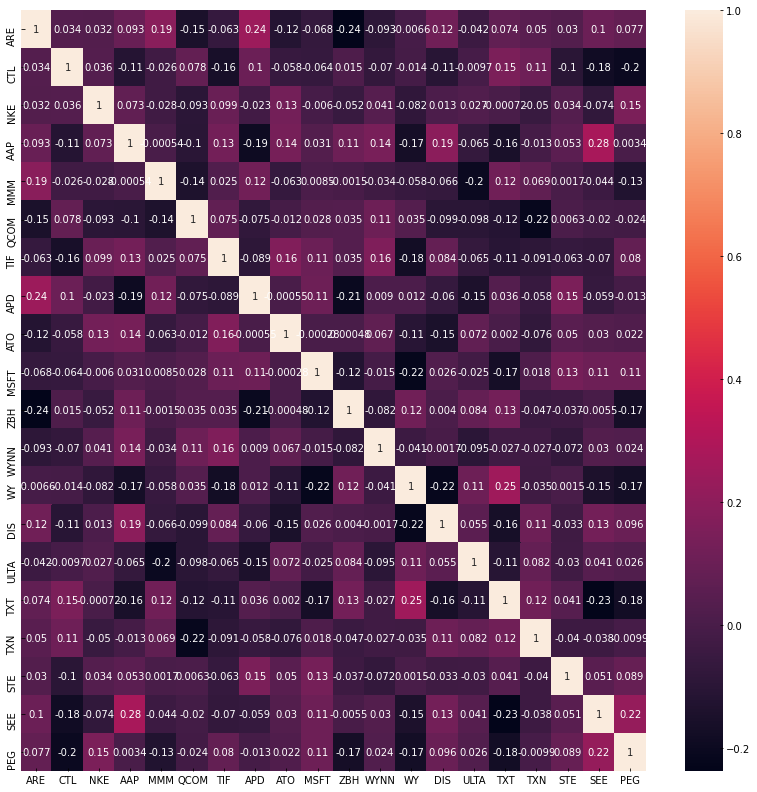

In [35]:
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True)
plt.show()

один шаг бектеста

In [36]:
def trade(alphas, positions, prices, i):
    new_positions = pd.DataFrame({}, columns=tickers, index=[0])
    new_positions_dollars = pd.DataFrame({}, columns=tickers, index=[0])
    cash = positions.iloc[0]['CASH']
    if cash < 0:
        print("Negative cash! Bankrupt! ", cash, " @ ", i)
        print(alphas)
        print('=======================================================')
        print(positions)
        print('=======================================================')
        print(prices)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    pv_ = cash
    for ticker in tickers:
        pv_ = pv_ + positions.iloc[0][ticker] * prices[ticker]
    expected_positions = alphas.iloc[0] * pv_
    max_pos = pv_ * MAX_POSITION_PER_EQUITY
    max_trade = pv_ * MAX_POSITION_PER_EQUITY_PER_TRADE
    for ticker in tickers:
        if abs(expected_positions[ticker]) > max_pos:
            expected_positions[ticker] = math.copysign(max_pos, expected_positions[ticker])
        
    eps = expected_positions.transpose()[expected_positions < 0].sort_values()
    epl = expected_positions.transpose()[expected_positions >= 0].sort_values(ascending=False)
    for ticker, _ in eps.iteritems():
        amount_to_buy = expected_positions[ticker] - positions.iloc[0][ticker] * prices[ticker]
        if abs(amount_to_buy) > max_trade:
            amount_to_buy = math.copysign(max_trade, amount_to_buy)
        number_of_shares = amount_to_buy // prices[ticker]
        cost = number_of_shares * prices[ticker]
        if abs(cost) < MIN_DEAL_SIZE:
            new_positions[ticker] = positions.iloc[0][ticker]
        else:
            total_cost = cost + abs(cost) * FEE
            if cash >= total_cost:
                cash = cash - total_cost
                new_positions[ticker] = positions.iloc[0][ticker] + number_of_shares
            else:
                available = (cash / (1 + FEE)) // prices[ticker]
                cash = cash - available * prices[ticker]
                new_positions[ticker] = positions.iloc[0][ticker] + available
    for ticker, _ in epl.iteritems():
        amount_to_buy = expected_positions[ticker] - positions.iloc[0][ticker] * prices[ticker]
        if abs(amount_to_buy) > max_trade:
            amount_to_buy = math.copysign(max_trade, amount_to_buy)
        number_of_shares = amount_to_buy // prices[ticker]
        cost = number_of_shares * prices[ticker]
        if abs(cost) < MIN_DEAL_SIZE:
            new_positions[ticker] = positions.iloc[0][ticker]
        else:
            total_cost = cost + abs(cost) * FEE
            if cash >= total_cost:
                cash = cash - total_cost
                new_positions[ticker] = positions.iloc[0][ticker] + number_of_shares
            else:
                available = (cash / (1 + FEE)) // prices[ticker]
                cash = cash - available * prices[ticker]
                new_positions[ticker] = positions.iloc[0][ticker] + available
    new_positions['CASH'] = cash    
    for ticker in tickers:
        new_positions_dollars[ticker] = new_positions.iloc[0][ticker] * prices[ticker]
    return pv_, new_positions, new_positions_dollars
    

бэктест

In [37]:
@jit
def backtest(nmkt_rets_df: pd.Series):
    init_positions = {}
    for ticker in tickers:
        init_positions[ticker] = 0
    init_positions['CASH'] = INITIAL_CASH
    positions = pd.DataFrame(init_positions, index=[0])
    positions_dollars = pd.DataFrame(init_positions, index=[0])

    pv_series = [INITIAL_CASH]
    window_size = GARCH_LAG*2+1 if MEAN_MODEL == 'HARX' else GARCH_LAG
    last_refit_date = window_size
    while last_refit_date < len(rp_df):
        nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[last_refit_date - window_size: last_refit_date])
        corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
        for offset in range(0, GARCH_REFIT_DELAY_DAYS):
            today = last_refit_date + offset + 1
            if today >= len(nmkt_rets_df):
                break
            alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
            alphas_array = alphas.to_numpy()
#             alpha_norma = 1
#             alpha_norma = abs(alphas_array[0]).mean()
            alpha_norma = alphas_array[0].sum()
            normalized_alphas = alphas / alpha_norma # / 100 * MAX_POSITION_PER_EQUITY
            pv, new_positions, new_positions_dollars = trade(normalized_alphas, positions.tail(1), rp_df.iloc[today], today)
            pv_series.append(pv)
            positions = positions.append(new_positions, ignore_index=True)
            positions_dollars = positions_dollars.append(new_positions_dollars, ignore_index=True)
        last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS
    return positions, pv_series, positions_dollars

In [38]:
%%time
warnings.filterwarnings('ignore')
positions, pv_series, position_dollars = backtest(nmkt_rets_df)

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 5. The message is:
Singular matrix E in LSQ subproblem
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

CPU times: user 29min 56s, sys: 28min 19s, total: 58min 16s
Wall time: 7min 28s


In [39]:
pv_s = pd.Series(pv_series)
pv_s.index = spy_p.index[-len(positions):]

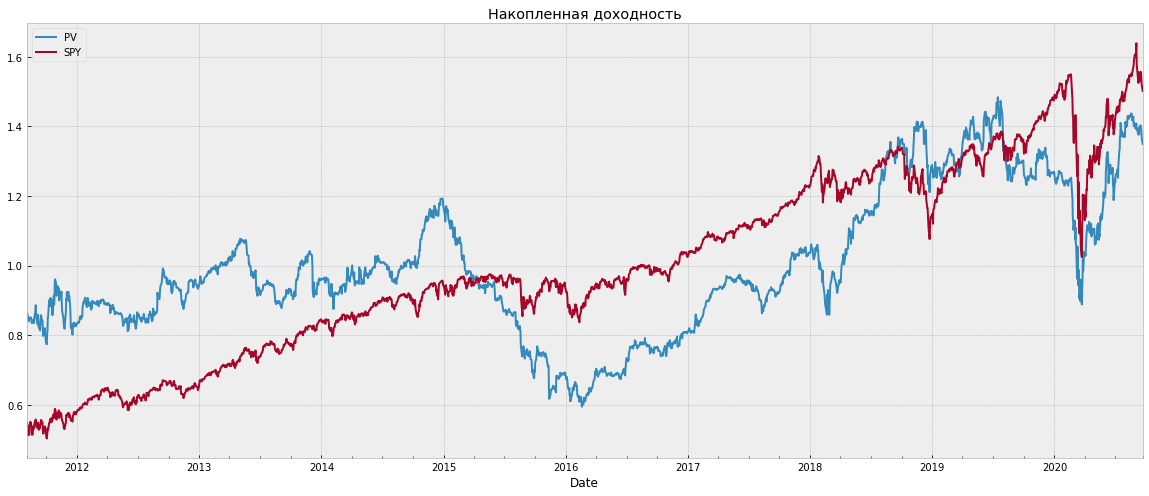

In [95]:
plt.figure(figsize=(20, 8))
plt.title('Накопленная доходность')
pic = (pv_s / pv_s.mean()).plot(label='PV')
pic.plot((spy_p[-len(positions):] / spy_p[-len(positions):].mean()), label='SPY')
plt.legend()
plt.savefig('pv with spy')

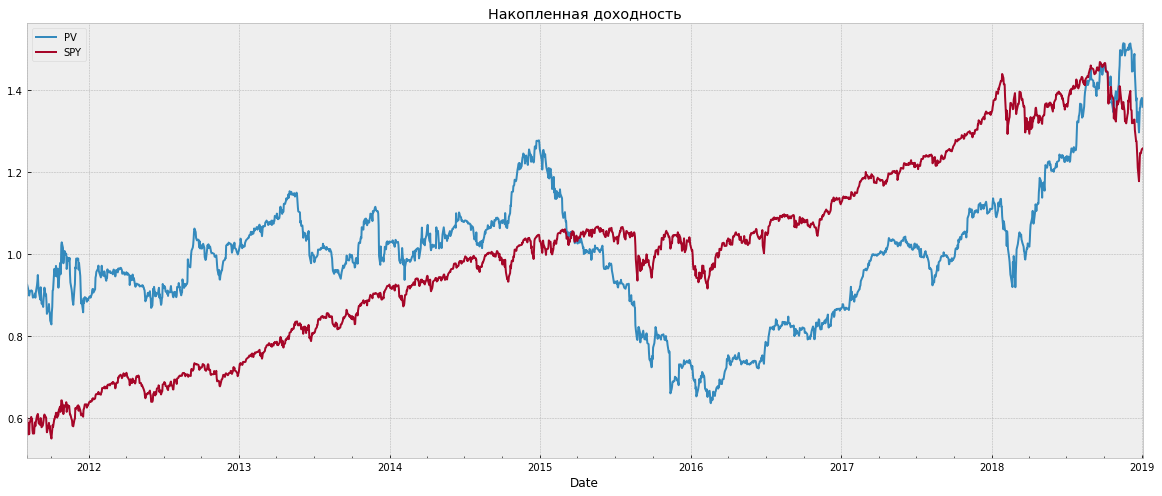

In [94]:
plt.figure(figsize=(20, 8))
plt.title('Накопленная доходность')
pic = (pv_s[:-433] / pv_s[:-433].mean()).plot(label='PV')
pic.plot((spy_p[-len(positions):-433] / spy_p[-len(positions):-433].mean()), label='SPY')
plt.legend()
plt.savefig('pv with spy 2010-2019')

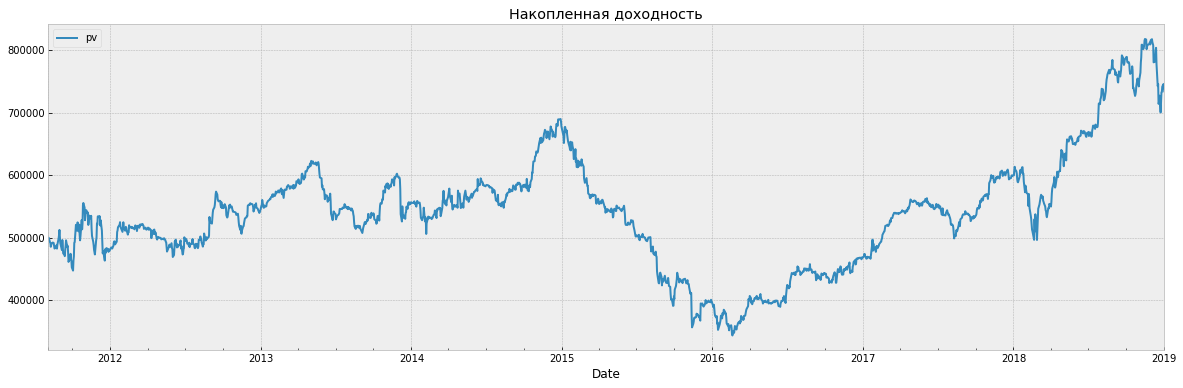

In [42]:
plt.figure(figsize=(20,6))
plt.title('Накопленная доходность')
pv_s[:-433].plot(label='pv')
plt.legend()
plt.savefig('pv series')

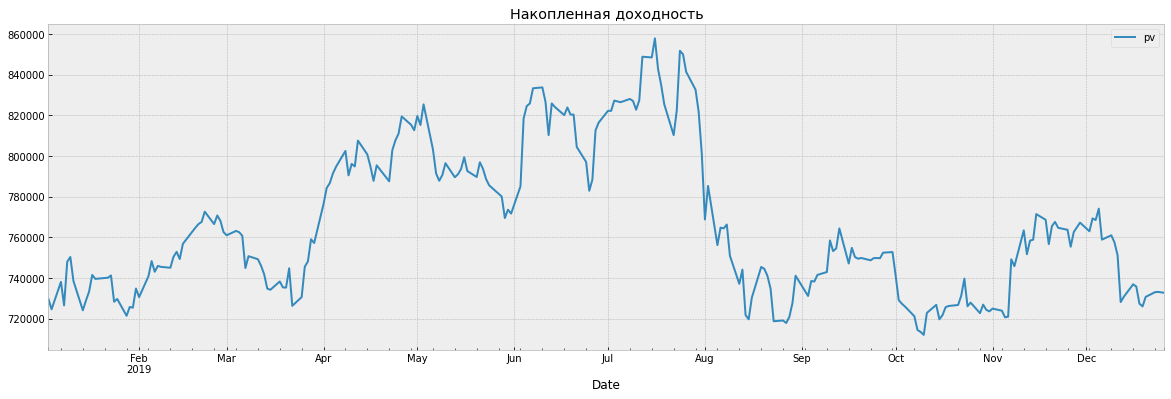

In [43]:
plt.figure(figsize=(20,6))
plt.title('Накопленная доходность')
pv_s[-433:-185].plot(label='pv')
plt.legend()
plt.savefig('2019-2020 pv series')

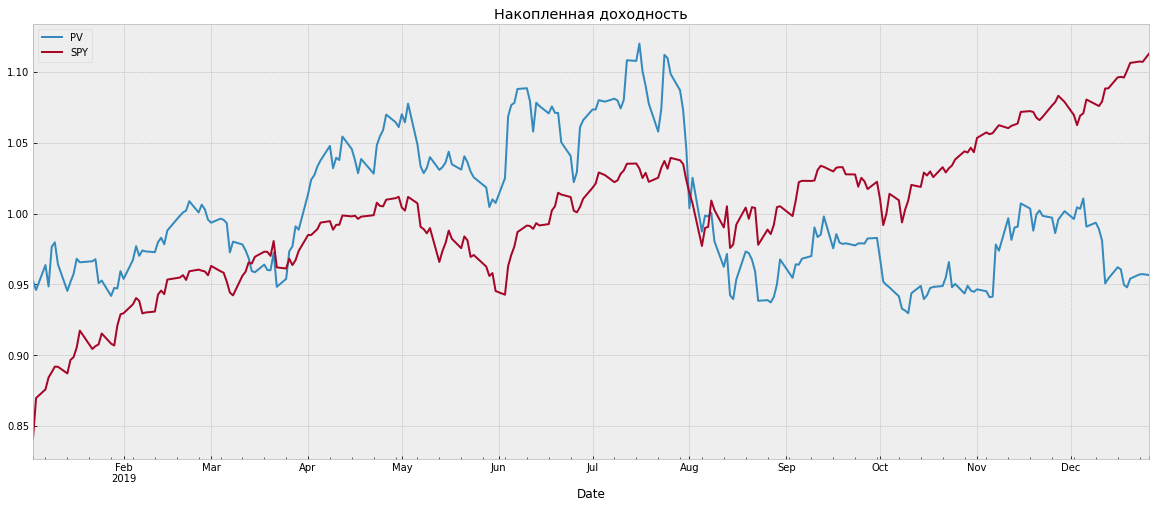

In [44]:
plt.figure(figsize=(20, 8))
plt.title('Накопленная доходность')
pic = (pv_s[-433:-185] / pv_s[-433:-185].mean()).plot(label='PV')
pic.plot((spy_p[-433:-185] / spy_p[-433:-185].mean()), label='SPY')
plt.legend()
plt.savefig('2019-2020 pv with spy')

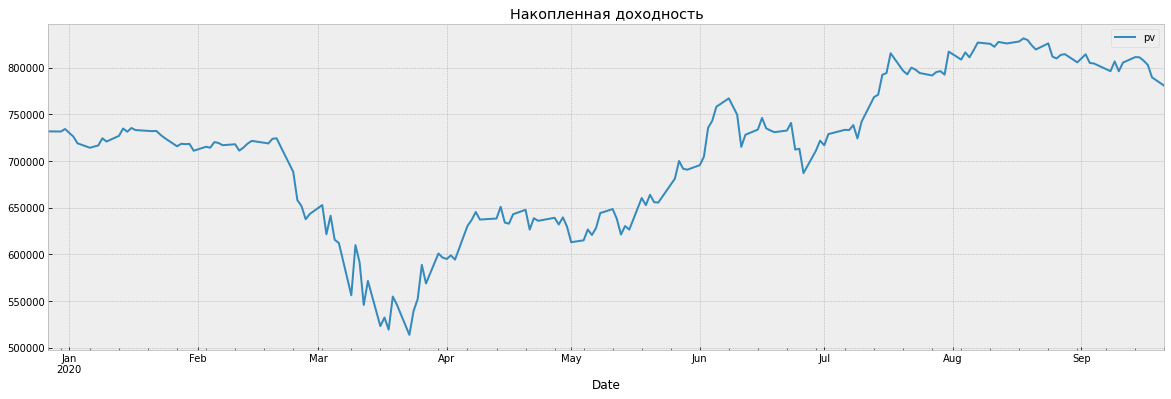

In [45]:
plt.figure(figsize=(20,6))
plt.title('Накопленная доходность')
pv_s[-185:].plot(label='pv')
plt.legend()
plt.savefig('2020+ pv series')

In [88]:
pv_s.head()

Date
2011-08-04    500000.000000
2011-08-05    500000.000000
2011-08-08    492932.559724
2011-08-09    491962.431616
2011-08-10    485490.738387
Freq: D, dtype: float64

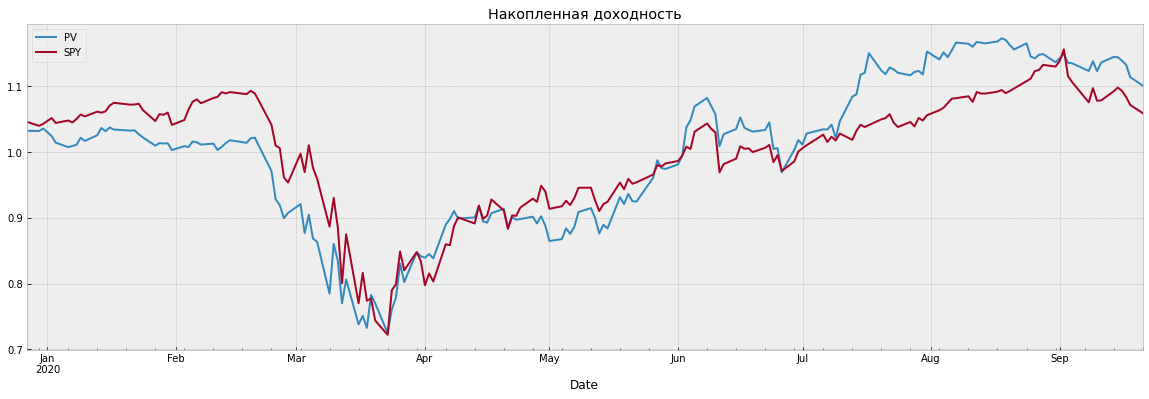

In [46]:
plt.figure(figsize=(20, 6))
plt.title('Накопленная доходность')
pic = (pv_s[-185:] / pv_s[-185:].mean()).plot(label='PV')
pic.plot((spy_p[-185:] / spy_p[-185:].mean()), label='SPY')
plt.legend()
plt.savefig('2020+ pv with spy')

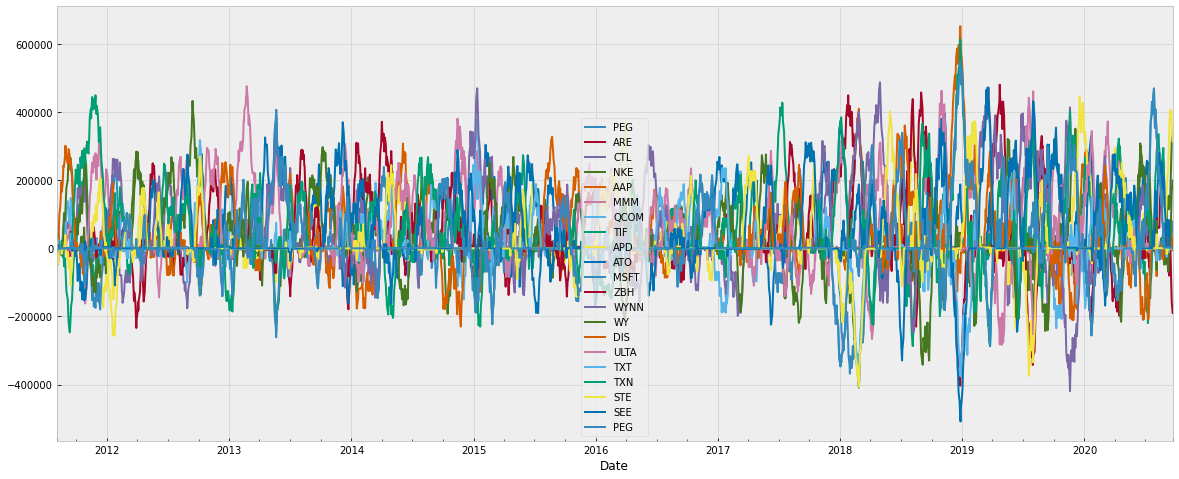

In [47]:
position_dollars.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20,8))
pt = position_dollars['PEG'].plot()
for ticker in tickers:
    pt.plot(position_dollars[ticker], label=ticker)
plt.legend()

позиции по каждой акции

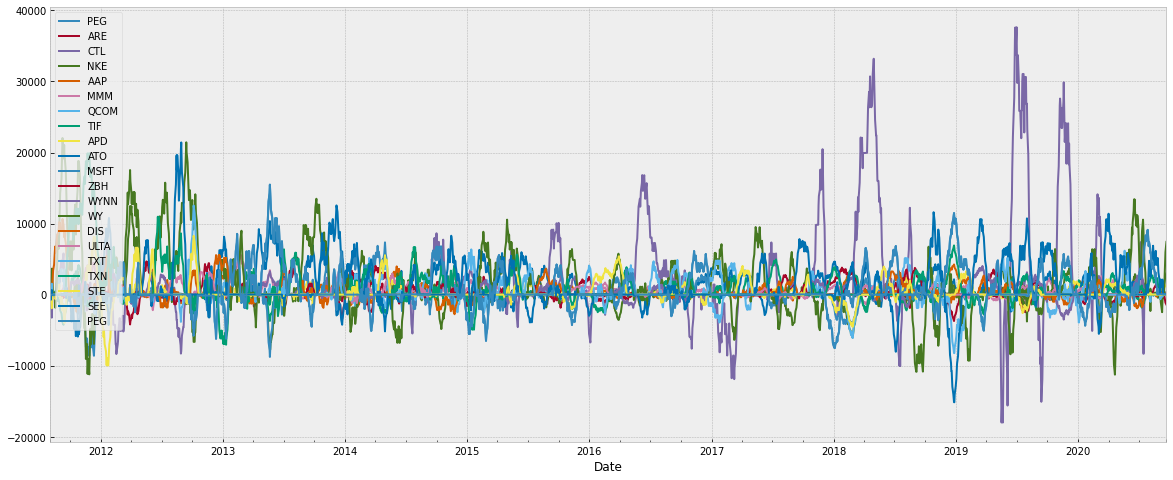

In [48]:
positions.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20,8))
pt = positions['PEG'].plot()
for ticker in tickers:
    pt.plot(positions[ticker], label=ticker)
plt.legend()

<AxesSubplot:xlabel='Date'>

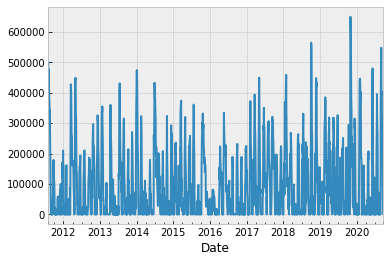

In [49]:
positions['CASH'].plot()

In [50]:
pnl = raw_adj_close_log_returns(pv_s)

In [51]:
pnl[:-433].mean() / pnl[:-433].std()

0.016677032019184714

In [52]:
pnl[-433:-185].mean() / pnl[-433:-185].std()

-0.0005763103196380874

In [53]:
pnl[-185:].mean() / pnl[-185:].std()

0.014512747198904047

In [54]:
pnl.mean() / pnl.std()

0.014316199952037383

In [55]:
beta(spy[:-433], pnl[:-433], lag=len(pnl) - 433)

0.12598225524658438

In [56]:
beta(spy[-433:-185], pnl[-433:-185], lag=433-185-1)

0.002785154696950184

In [57]:
beta(spy[-185:], pnl[-185:], lag=185-1)

0.0042189706310264445

In [58]:
beta(spy, pnl, lag=len(pnl))

0.1143134756704789

In [59]:
def rachev(pnl_abs):
    reverse_pnl = -pnl_abs
    loss_var = pnl_abs.quantile(0.05)
    win_var = reverse_pnl.quantile(0.05)
    loss_es = pnl_abs[pnl_abs < loss_var].mean()
    win_es = reverse_pnl[reverse_pnl < win_var].mean()
    rachev = win_es / loss_es
    return rachev



In [60]:
rachev(pnl[:-433].diff())

1.0088253454269818

In [61]:
rachev(pnl[-433:-185].diff())

0.9788797701233226

In [62]:
rachev(pnl[-185:].diff())

1.180370736352185

In [63]:
rachev(pnl.diff())

1.0271221882079296

конечный PV

In [89]:
total_return = (pv_s[-1] - INITIAL_CASH) / INITIAL_CASH
total_return / (5+12*8+9) * 12

0.06117537663163487

In [90]:
total_return = (pv_s[-1] - pv_s[-185]) / INITIAL_CASH
total_return / 9 * 12

0.12981167158804213

In [91]:
total_return = (pv_s[-185] - pv_s[-433]) / INITIAL_CASH
total_return

0.004194566142844036

In [92]:
total_return = (pv_s[-433] - pv_s[0]) / INITIAL_CASH
total_return / (5 + 12*7) * 12

0.061917433612059876

<AxesSubplot:xlabel='Date'>

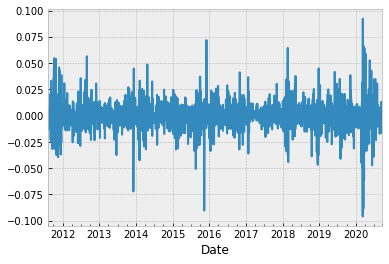

In [68]:
pnl = raw_adj_close_log_returns(pv_s)
pnl.plot()

<AxesSubplot:xlabel='Date'>

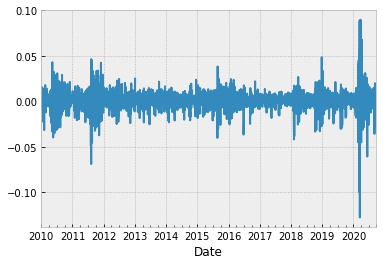

In [69]:
spy.plot()

In [70]:
pnl_abs = pv_s.diff()

In [71]:
max_dd_daily = pnl_abs[:-433].min() / INITIAL_CASH
max_dd_daily

-0.08033550893410878

In [72]:
max_dd_daily_t = pv_s[-433:-185].diff().min() / INITIAL_CASH
max_dd_daily_t

-0.08033550893410878

In [73]:
max_dd_daily_r = pv_s[-185:].diff().min() / INITIAL_CASH
max_dd_daily_r

-0.11191068730753707

In [74]:
max_dd_weekly = 0
for i in range(7, len(pnl_abs)):
    dd = pnl_abs[i - 7: i].max() - pnl_abs[i - 7: i].min()
    if dd > max_dd_weekly:
        max_dd_weekly = dd
max_dd_weekly / INITIAL_CASH

0.2193232646857491

In [93]:
max_dd_weekly = 0
pnl_t = pv_s[:-433].diff()
for i in range(7, len(pnl_t)):
    dd = pnl_t.max() - pnl_t[i - 7: i].min()
    if dd > max_dd_weekly:
        max_dd_weekly = dd
max_dd_weekly / INITIAL_CASH

0.14644012207195697

In [75]:
max_dd_weekly_t = 0
pnl_t = pv_s[-433:-185].diff()
for i in range(7, len(pnl_t)):
    dd = pnl_t.max() - pnl_t[i - 7: i].min()
    if dd > max_dd_weekly_t:
        max_dd_weekly_t = dd
max_dd_weekly_t / INITIAL_CASH

0.14705560408079157

In [76]:
max_dd_weekly_r = 0
pnl_r = pv_s[-185:].diff()
for i in range(7, len(pnl_t)):
    dd = pnl_r.max() - pnl_r[i - 7: i].min()
    if dd > max_dd_weekly_r:
        max_dd_weekly_r = dd
max_dd_weekly_r / INITIAL_CASH

0.2193232646857491

In [77]:
beta(spy[-len(pnl):], pnl, lag=len(pnl)-1)

0.00032793422115492293

In [ ]:
sharp = pnl.mean() / pnl.std()
sharp

In [ ]:
def var_graph(ret: pd.Series):
    VaR_HS_01 = ret.quantile(0.01)
    VaR_HS_05 = ret.quantile(0.05)

    fig = plt.figure(figsize=(16, 5))

    sns.distplot(ret, hist=True, kde=False,
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

    plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
    plt.axvline(x=VaR_HS_05, linewidth=4, color="y")

    plt.title("Histogram of daily returns", weight="bold")

    plt.legend(['VaR for alpha=1%: {:.2f}'.format(VaR_HS_01),
            'VaR for alpha=5%: {:.2f}'.format(VaR_HS_05)], fontsize=12)

In [ ]:
# var_graph(pnl_abs)


In [ ]:
def calculate_VaR_garch(returns, alpha):
    scaling_const = 10.0 / returns.std()
    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1,
                    vol='Garch', p=1, o=1, q=1,
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = 1
    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    return VaR_garch_forecast


In [ ]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)

    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)

    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [ ]:
%%time
var_5 = calc_VaR(pnl_abs.dropna(), calculate_VaR_garch, level=0.05)



In [ ]:
plt.figure(figsize=(20, 7))
p = var_5.plot(label='VaR')
p.plot(pnl_abs.dropna(), label='PnL')
plt.legend()
plt.title('P&L Value at Risk')
plt.savefig("var")

In [ ]:
reverse_pnl = -pnl_abs
loss_var = pnl_abs.quantile(0.05)
win_var = reverse_pnl.quantile(0.05)
loss_es = pnl_abs[pnl_abs < loss_var].mean()
win_es = reverse_pnl[reverse_pnl < win_var].mean()
rachev = win_es / loss_es
rachev



In [ ]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [ ]:
hits = calc_hits(pnl_abs, var_5)
hits.mean()


0.014316199952037383

In [79]:
def var_graph(ret: pd.Series):
    VaR_HS_01 = ret.quantile(0.01)
    VaR_HS_05 = ret.quantile(0.05)

    fig = plt.figure(figsize=(16, 5))

    sns.distplot(ret, hist=True, kde=False,
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

    plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
    plt.axvline(x=VaR_HS_05, linewidth=4, color="y")

    plt.title("Histogram of daily returns", weight="bold")

    plt.legend(['VaR for alpha=1%: {:.2f}'.format(VaR_HS_01),
            'VaR for alpha=5%: {:.2f}'.format(VaR_HS_05)], fontsize=12)

In [80]:
# var_graph(pnl_abs)


In [81]:
def calculate_VaR_garch(returns, alpha):
    scaling_const = 10.0 / returns.std()
    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1,
                    vol='Garch', p=1, o=1, q=1,
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = 1
    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    return VaR_garch_forecast


In [82]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)

    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)

    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [83]:
%%time
var_5 = calc_VaR(pnl_abs.dropna(), calculate_VaR_garch, level=0.05)



CPU times: user 4min 46s, sys: 1min 25s, total: 6min 12s
Wall time: 3min 7s


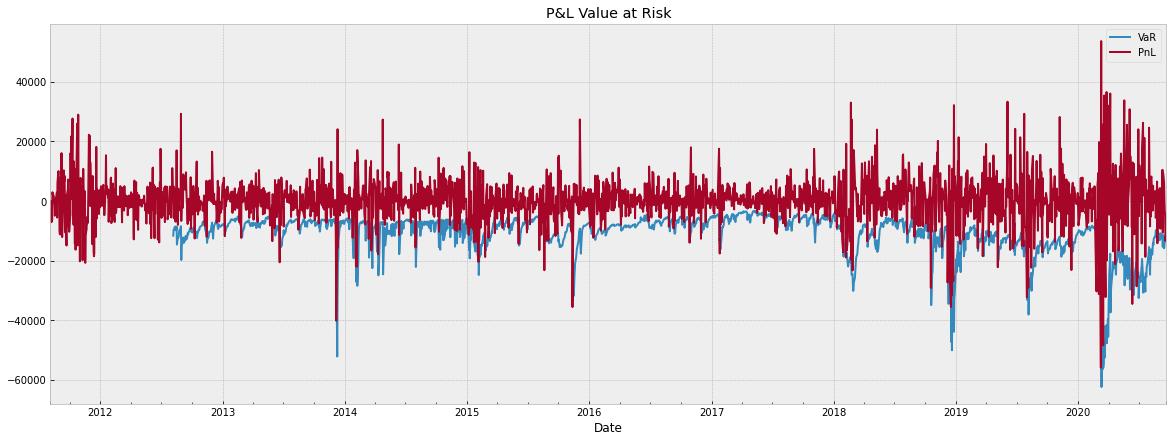

In [84]:
plt.figure(figsize=(20, 7))
p = var_5.plot(label='VaR')
p.plot(pnl_abs.dropna(), label='PnL')
plt.legend()
plt.title('P&L Value at Risk')
plt.savefig("var")

In [85]:
reverse_pnl = -pnl_abs
loss_var = pnl_abs.quantile(0.05)
win_var = reverse_pnl.quantile(0.05)
loss_es = pnl_abs[pnl_abs < loss_var].mean()
win_es = reverse_pnl[reverse_pnl < win_var].mean()
rachev = win_es / loss_es
rachev



0.9844478992869076

In [86]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [87]:
hits = calc_hits(pnl_abs, var_5)
hits.mean()


0.06454767726161369